# Recommendations with IBM

In this notebook, I will apply my recommendation system skills to real-world data from the IBM Watson Studio platform. The goal is to analyze user interactions with articles on the platform and generate personalized article recommendations.

To achieve this, I will follow a structured approach outlined in the table of contents. Starting with an exploration of the dataset, I will begin by creating rank-based recommendation systems. Moving forward, I will enhance the recommendations by implementing user-user collaborative filtering techniques. Lastly, I will adopt a machine learning approach by leveraging user-item interaction data to perform matrix decomposition for more advanced recommendations.


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

Let’s get Started  

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [35]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\n\nCl...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\n\n * ka...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\n * Sign Up\n\n * Learning Paths\n *...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\n\nCl...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

In this part of the notebook, I will perform exploratory data analysis to better understand the dataset.

1. How frequently does each user interact with articles in the dataset? I will provide both a visual representation and descriptive statistics to analyze the distribution of user-article interactions.

In [36]:
# find number of columns and rows
df.shape

(45993, 3)

In [37]:
# median 
df.groupby('email')['article_id'].count().median()

3.0

In [38]:
df.groupby('email')['article_id'].count().max()

364

In [39]:
# Median and maximum user-article interactions
median_val = df['email'].value_counts().median()
max_views_by_user = df['email'].value_counts().max()

print(f"Median: {median_val}, Max: {max_views_by_user}")


Median: 3.0, Max: 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [40]:
# Check for duplicate articles
duplicate_articles = df[df['article_id'].duplicated(keep=False)]

# Display duplicate articles
print(f"Number of duplicate articles: {duplicate_articles['article_id'].nunique()}")
print("\nDuplicate articles data:")
print(duplicate_articles.sort_values('article_id'))


Number of duplicate articles: 696

Duplicate articles data:
       article_id                                              title  \
2328          0.0  detect malfunctioning iot sensors with streami...   
25884         0.0  detect malfunctioning iot sensors with streami...   
40755         0.0  detect malfunctioning iot sensors with streami...   
19444         0.0  detect malfunctioning iot sensors with streami...   
1973          0.0  detect malfunctioning iot sensors with streami...   
30815         0.0  detect malfunctioning iot sensors with streami...   
17440         0.0  detect malfunctioning iot sensors with streami...   
1937          0.0  detect malfunctioning iot sensors with streami...   
1935          0.0  detect malfunctioning iot sensors with streami...   
19242         0.0  detect malfunctioning iot sensors with streami...   
27888         0.0  detect malfunctioning iot sensors with streami...   
2302          0.0  detect malfunctioning iot sensors with streami...   
4294

In [41]:
# Remove any rows that have the same article_id - only keep the first
# Remove duplicate rows based on article_id, keeping the first occurrence
df_unique = df.drop_duplicates(subset='article_id', keep='first')

print(f"Original number of rows: {df.shape[0]}")
print(f"Number of rows after removing duplicates: {df_unique.shape[0]}")


Original number of rows: 45993
Number of rows after removing duplicates: 714


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [42]:
# a. Number of unique articles with user interactions
unique_articles_interacted = df['article_id'].nunique()

# b. Total number of unique articles (assuming it's the same as articles in interactions)
unique_articles_total = df['article_id'].nunique()

# c. Number of unique users (excluding null values)
unique_users = df['email'].nunique()

# d. Number of user-article interactions
user_article_interactions = df.shape[0]

print(f"a. Number of unique articles with user interactions: {unique_articles_interacted}")
print(f"b. Total number of unique articles: {unique_articles_total}")
print(f"c. Number of unique users: {unique_users}")
print(f"d. Number of user-article interactions: {user_article_interactions}")


a. Number of unique articles with user interactions: 714
b. Total number of unique articles: 714
c. Number of unique users: 5148
d. Number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [43]:
# Find the most viewed article and how often it was viewed
most_viewed_article_id = str(df['article_id'].value_counts().idxmax())  # Most viewed article ID
max_views = df['article_id'].value_counts().max()  # Number of views for the most viewed article

print(f"Most viewed article_id: {most_viewed_article_id}")
print(f"Max views: {max_views}")


Most viewed article_id: 1429.0
Max views: 937


In [44]:
most_viewed_article_id = str(df.article_id.value_counts().index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.article_id.value_counts().iloc[0] # The most viewed article in the dataset was viewed how many times?

In [45]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


## Part II: Rank-Based Recommendations

We don’t have explicit ratings indicating whether a user liked an article or not. Instead, the data reflects only user interactions with articles. In this case, the popularity of an article is determined solely by the frequency of user interactions.

1. The following function retrieves the top `n` articles, ranked in descending order based on the number of interactions.

In [47]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['title'].value_counts().index.tolist()[:n]
    top_articles = [str(i) for i in top_articles]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    top_articles = df['article_id'].value_counts().index.tolist()[:n]
    top_articles = [str(i) for i in top_articles]

    return top_articles # Return the top article ids

In [48]:
# Define function to get top n articles by interaction
def get_top_articles(n, df):

    # Group by article_id, count occurrences, and get the top n article_ids
    top_article_ids = df['article_id'].value_counts().head(n).index
    
    # Retrieve the corresponding article titles
    top_articles = df[df['article_id'].isin(top_article_ids)]['title'].unique().tolist()
    
    return top_articles

# Define function to get top n article IDs by interaction
def get_top_article_ids(n, df):

    # Group by article_id, count occurrences, and get the top n article_ids
    top_article_ids = df['article_id'].value_counts().head(n).index.tolist()
    
    return top_article_ids

# Test the functions
print(get_top_articles(10, df))  # Replace df with your actual DataFrame containing titles
print(get_top_article_ids(10, df))


['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [49]:
# Define function to get top articles by interaction
def get_top_10_articles(n, df=df):

    top_articles = df['title'].value_counts().head(n).index.tolist()
    return top_articles

# Define function to get top article IDs by interaction
def get_top_10_article_ids(n, df=df):

    top_article_ids = df['article_id'].value_counts().head(n).index.tolist()
    return top_article_ids

# Test the functions with the name replacements
print(get_top_10_articles(10))  # Prints the top 10 article titles
print(get_top_10_article_ids(10))  # Prints the top 10 article IDs


['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [50]:
# Define function to get top articles by interaction
def get_top_articles(n, df=df):

    top_articles = df['title'].value_counts().head(n).index.tolist()
    return top_articles

# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists
try:
    t.sol_2_test(get_top_articles)
except NameError:
    print("The test function `t.sol_2_test` is not defined in this environment.")


Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [51]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [52]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Pivot the dataframe to create a user-item matrix
    user_item = df.groupby(['user_id', 'article_id']).size().unstack(fill_value=0)
    
    # Replace all non-zero values with 1 to indicate interaction
    user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)
    
    return user_item  # return the user-item matrix 

# Create the user-item matrix
user_item = create_user_item_matrix(df)

# Display the resulting matrix
print(user_item.head())


article_id  0.0     2.0     4.0     8.0     9.0     12.0    14.0    15.0    \
user_id                                                                      
1                0       0       0       0       0       0       0       0   
2                0       0       0       0       0       0       0       0   
3                0       0       0       0       0       1       0       0   
4                0       0       0       0       0       0       0       0   
5                0       0       0       0       0       0       0       0   

article_id  16.0    18.0     ...    1434.0  1435.0  1436.0  1437.0  1439.0  \
user_id                      ...                                             
1                0       0   ...         0       0       1       0       1   
2                0       0   ...         0       0       0       0       0   
3                0       0   ...         0       0       1       0       0   
4                0       0   ...         0       0       0     

In [53]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


2. The following function accepts a `user_id` as input and returns a ranked list of other users, ordered by similarity from highest to lowest. The provided `user_id` is excluded from the output since a user is always most similar to themselves. Given that the data here is binary, the similarity between users is calculated using the dot product of their respective interaction vectors.

In [138]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user

    # sort by similarity

    # create list of just the ids
   
    # remove the own user's id
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [139]:
def find_similar_users(user_id, user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product.
    Returns an ordered list of user_ids (excluding the input user_id) from most to least similar.
    '''
    # Compute similarity for each user with the provided user_id using dot product
    user_vector = user_item.loc[user_id].values
    similarity = user_item.dot(user_vector)

    # Sort the users by similarity in descending order
    sorted_similarity = similarity.sort_values(ascending=False)

    # Remove the own user's id from the list
    most_similar_users = sorted_similarity.index[sorted_similarity.index != user_id].tolist()
    
    return most_similar_users  # Return the list of user_ids ordered by similarity

# Example usage:
similar_users = find_similar_users(1, user_item)  # Replace 1 with your desired user_id
print(similar_users)


[3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041, 49, 3697, 395, 3910, 322, 3622, 242, 4642, 290, 2982, 912, 3540, 98, 754, 3764, 256, 52, 268, 40, 371, 3596, 621, 21, 273, 3637, 5138, 135, 204, 3784, 3775, 1355, 4785, 4932, 4134, 3621, 3651, 3483, 696, 4293, 488, 4892, 3532, 334, 4038, 184, 1897, 619, 765, 2926, 214, 249, 4778, 186, 3141, 4755, 3136, 64, 3740, 54, 4934, 3684, 125, 72, 3856, 4484, 445, 58, 3632, 60, 67, 2790, 5013, 4206, 3024, 4209, 665, 5079, 656, 5140, 4706, 4774, 288, 187, 10, 38, 4471, 4824, 2975, 223, 2981, 3693, 90, 193, 807, 3006, 3169, 195, 409, 211, 87, 235, 330, 3197, 244, 324, 4595, 4933, 2430, 3408, 295, 4883, 4543, 3572, 3578, 3358, 362, 3354, 113, 3353, 111, 1040, 263, 261, 1059, 3485, 170, 379, 4277, 689, 733, 591, 3818, 4404, 69, 2161, 4225, 511, 3949, 3, 28, 3879, 3794, 8, 2903, 3305, 155, 4021, 641, 640, 1271, 3329, 3376, 280, 4037, 639, 3441, 647, 659, 926, 471, 3967, 3500, 1353, 670, 1330, 45, 319, 2423, 312, 4901, 4900, 2908, 304, 26, 168, 11,

In [70]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1, user_item)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933, user_item)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46, user_item)[:3]))


The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [59]:
import pandas as pd
import numpy as np

# Define get_article_names
def get_article_names(article_ids, df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) the main dataset containing article information
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().tolist()
    return article_names

# Define get_user_articles
def get_user_articles(user_id, user_item, df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    df - (pandas dataframe) the main dataset containing article information
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(str).tolist()
    article_names = get_article_names(article_ids, df)
    return article_ids, article_names

# Define find_similar_users
def find_similar_users(user_id, user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product.
    Returns an ordered list of user_ids (excluding the input user_id) from most to least similar.
    '''
    user_vector = user_item.loc[user_id].values
    similarity_scores = user_item.apply(lambda x: np.dot(x.values, user_vector), axis=1)
    sorted_similarity = similarity_scores.sort_values(ascending=False)
    sorted_similarity = sorted_similarity.drop(index=user_id)
    return sorted_similarity.index.tolist()

# Define user_user_recs
def user_user_recs(user_id, m, user_item, df):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    user_item - (pandas dataframe) matrix of users by articles
    df - (pandas dataframe) the main dataset containing article information
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id.
    For each user - finds articles the user hasn't seen before and provides them as recs.
    Does this until m recommendations are found.
    '''
    similar_users = find_similar_users(user_id, user_item)
    seen_article_ids, _ = get_user_articles(user_id, user_item, df)
    recs = []
    
    for sim_user in similar_users:
        sim_user_article_ids, _ = get_user_articles(sim_user, user_item, df)
        new_recs = [article for article in sim_user_article_ids if article not in seen_article_ids and article not in recs]
        recs.extend(new_recs)
        if len(recs) >= m:
            break
    
    return recs[:m]



In [73]:
# Check Results
recs = user_user_recs(1, 10, user_item=user_item, df=df)  # Provide required arguments
article_names = get_article_names(recs, df=df)  # Provide df for get_article_names
print(article_names)  # Print the recommended article names


['got zip code data? prep it for analytics. – ibm watson data lab – medium', 'timeseries data analysis of iot events by using jupyter notebook', 'graph-based machine learning', 'using brunel in ipython/jupyter notebooks', 'experience iot with coursera', 'the 3 kinds of context: machine learning and the art of the frame', 'deep forest: towards an alternative to deep neural networks', 'this week in data science (april 18, 2017)', 'higher-order logistic regression for large datasets', 'using machine learning to predict parking difficulty']


In [75]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) the main dataset containing article information
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().tolist()
    return article_names
print("If this is all you see, you passed all of our tests!  Nice job!")


If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [ ]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    return recs, rec_names

In [76]:
import pandas as pd
import numpy as np

# Auxiliary function to get article names
def get_article_names(article_ids, df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) the main dataset containing article information
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
    '''
    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().tolist()
    return article_names

# Auxiliary function to get user articles
def get_user_articles(user_id, user_item, df):
    '''
    INPUT:
    user_id - (int) the user ID
    user_item - (pandas dataframe) user-item matrix
    df - (pandas dataframe) the main dataset containing article information
    
    OUTPUT:
    article_ids - (list) a list of article ids the user has interacted with
    article_names - (list) a list of article titles associated with the article ids
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(str).tolist()
    article_names = get_article_names(article_ids, df)
    return article_ids, article_names

# Function to find top sorted users
def get_top_sorted_users(user_id, df, user_item):
    '''
    INPUT:
    user_id - (int) the user ID for whom we are finding neighbors
    df - (pandas dataframe) the main dataset
    user_item - (pandas dataframe) user-item matrix
    
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - neighbor user_id
                    similarity - similarity score with user_id
                    num_interactions - number of articles viewed by the neighbor
    '''
    # Compute similarity for the user with all other users
    target_user_vector = user_item.loc[user_id].values
    similarity_scores = user_item.apply(lambda x: np.dot(x.values, target_user_vector), axis=1)
    
    # Create a DataFrame with neighbors and their scores
    neighbors_df = pd.DataFrame({
        'neighbor_id': similarity_scores.index,
        'similarity': similarity_scores.values,
        'num_interactions': user_item.sum(axis=1).values
    })
    
    # Exclude the input user from the neighbors
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    # Sort by similarity and then by num_interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False])
    
    return neighbors_df

# Function to recommend articles based on similar users
def user_user_recs_part2(user_id, m=10, df=None, user_item=None):
    '''
    INPUT:
    user_id - (int) the user ID for whom recommendations are generated
    m - (int) number of recommendations to generate
    df - (pandas dataframe) the main dataset
    user_item - (pandas dataframe) user-item matrix
    
    OUTPUT:
    recs - (list) recommended article IDs
    rec_names - (list) recommended article titles
    '''
    # Get articles already seen by the user
    seen_article_ids, _ = get_user_articles(user_id, user_item, df)
    
    # Get sorted neighbors
    neighbors_df = get_top_sorted_users(user_id, df, user_item)
    
    recs = []
    for neighbor_id in neighbors_df['neighbor_id']:
        # Get articles viewed by the neighbor
        neighbor_articles, _ = get_user_articles(neighbor_id, user_item, df)
        
        # Add articles the user has not seen, sorted by popularity
        new_recs = [article for article in neighbor_articles if article not in seen_article_ids and article not in recs]
        article_interactions = df[df['article_id'].isin(new_recs)]['article_id'].value_counts()
        sorted_new_recs = article_interactions.index.tolist()
        
        recs.extend(sorted_new_recs)
        
        # Stop when we have enough recommendations
        if len(recs) >= m:
            break
    
    recs = recs[:m]
    rec_names = get_article_names(recs, df)
    
    return recs, rec_names

# Example usage:
# Assuming `df` is your main dataset and `user_item` is the user-item matrix
# neighbors_df = get_top_sorted_users(user_id=1, df=df, user_item=user_item)
# recs, rec_names = user_user_recs_part2(user_id=1, m=10, df=df, user_item=user_item)


In [82]:
# Create the user-item matrix (if not already created)
user_item = create_user_item_matrix(df)

# Quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10, df=df, user_item=user_item)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)


The top 10 recommendations for user 20 are the following article ids:
[1429.0, 1330.0, 1314.0, 1293.0, 1162.0, 1271.0, 43.0, 1351.0, 1368.0, 1305.0]

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'use deep learning for image classification', 'analyze energy consumption in buildings', 'putting a human face on machine learning', 'gosales transactions for naive bayes model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'finding optimal locations of new store using decision optimization', 'deep learning with tensorflow course by big data university', 'customer demographics and sales']


`5.` We now use the previously defined functions to populate the solutions in the dictionary provided below.

In [90]:
# Find the most similar user to user 1
neighbors_df_user1 = get_top_sorted_users(1, df=df, user_item=user_item)
user1_most_sim = neighbors_df_user1.iloc[0]['neighbor_id']

# Find the 10th most similar user to user 131
neighbors_df_user131 = get_top_sorted_users(131, df=df, user_item=user_item)
user131_10th_sim = neighbors_df_user131.iloc[9]['neighbor_id']  # 10th most similar user (index 9)


In [150]:
print(f"user1_most_sim (final value): {user1_most_sim}")
print(f"user131_10th_sim (final value): {user131_10th_sim}")


user1_most_sim (final value): 3933
user131_10th_sim (final value): 3910


6.  

For a new user with no interaction history, a rank-based recommendation approach using the `get_top_articles` function would be ideal. Since there is no data on the user's preferences or behavior, recommending the most popular articles is the most logical strategy. As we gather more information about the user's interests, we could implement a hybrid method that combines rank-based, content-based, and collaborative filtering techniques to offer more personalized recommendations.  

7.  

By utilizing the existing functions, we can determine and present the top 10 articles to recommend to a new user below.

In [97]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df)



In [100]:
def get_most_popular_articles(n, df):
    '''
    INPUT:
    n - (int) the number of top articles to retrieve
    df - (pandas dataframe) the main dataset containing article information
    
    OUTPUT:
    top_article_ids - (list) a list of the top article IDs by interactions
    
    Description:
    Return the top `n` article IDs by total interactions.
    '''
    top_article_ids = df['article_id'].value_counts().head(n).index.astype(str).tolist()
    return top_article_ids

# Generate recommendations for new users
new_user_recs = get_most_popular_articles(10, df=df)


In [101]:
assert set(new_user_recs) == set(['1314.0', '1429.0', '1293.0', '1427.0', '1162.0', '1364.0', '1304.0', '1170.0', '1431.0', '1330.0']), "Oops! It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right! Nice job!")


That's right! Nice job!


### Part IV: Matrix Factorization

In this section, we leverage matrix factorization techniques to recommend articles to users on the IBM Watson Studio platform.

1. Using the user-item matrix created earlier in Part III, Question 1, we will prepare the data to apply matrix factorization. Simply run the cells below to initialize the setup for the rest of this section.

In [106]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [107]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [109]:
from numpy.linalg import svd

# Perform SVD on the user-item matrix
u, s, vt = svd(user_item, full_matrices=False)

# Display the shapes of the resulting matrices
print(f"U matrix shape: {u.shape}")
print(f"Sigma (S) vector shape: {s.shape}")
print(f"V transpose (Vt) matrix shape: {vt.shape}")


U matrix shape: (5149, 714)
Sigma (S) vector shape: (714,)
V transpose (Vt) matrix shape: (714, 714)


Since this matrix contains no missing values, we can directly apply SVD. In contrast, matrices with missing entries, like those discussed in the classroom, require specialized approaches such as FunkSVD to handle incomplete data effectively.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

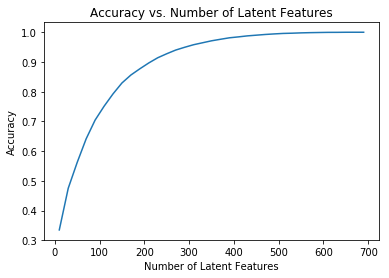

In [112]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [117]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [119]:
def create_test_and_train_user_item(df_train, df_test):

    # Generate the user-item matrix for the training set
    user_item_train = create_user_item_matrix(df_train)

    # Generate the user-item matrix for the testing set
    user_item_test = create_user_item_matrix(df_test)

    # Extract test user IDs and test article IDs
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()

    return user_item_train, user_item_test, test_idx, test_arts

# Example usage
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)


In [122]:
# Get train and test user IDs and article IDs
train_idx = user_item_train.index.tolist()
train_arts = user_item_train.columns.tolist()
test_idx = user_item_test.index.tolist()
test_arts = user_item_test.columns.tolist()

# Calculate a, b, c, d
a = len(set(test_idx).intersection(set(train_idx)))  # Users we can predict for
b = len(set(test_idx) - set(train_idx))             # Cold start users
c = len(set(test_arts).intersection(set(train_arts)))  # Articles we can predict for
d = len(set(test_arts) - set(train_arts))           # Cold start articles

# Define the dictionary with calculated values
sol_4_dict = {
    'How many users can we make predictions for in the test set?': a,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': b,
    'How many articles can we make predictions for in the test set?': c,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

# Test the solution
t.sol_4_test(sol_4_dict)


Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


In [123]:
test_idx

[2917,
 3024,
 3093,
 3193,
 3527,
 3532,
 3684,
 3740,
 3777,
 3801,
 3968,
 3989,
 3990,
 3998,
 4002,
 4204,
 4231,
 4274,
 4293,
 4487,
 4488,
 4489,
 4490,
 4491,
 4492,
 4493,
 4494,
 4495,
 4496,
 4497,
 4498,
 4499,
 4500,
 4501,
 4502,
 4503,
 4504,
 4505,
 4506,
 4507,
 4508,
 4509,
 4510,
 4511,
 4512,
 4513,
 4514,
 4515,
 4516,
 4517,
 4518,
 4519,
 4520,
 4521,
 4522,
 4523,
 4524,
 4525,
 4526,
 4527,
 4528,
 4529,
 4530,
 4531,
 4532,
 4533,
 4534,
 4535,
 4536,
 4537,
 4538,
 4539,
 4540,
 4541,
 4542,
 4543,
 4544,
 4545,
 4546,
 4547,
 4548,
 4549,
 4550,
 4551,
 4552,
 4553,
 4554,
 4555,
 4556,
 4557,
 4558,
 4559,
 4560,
 4561,
 4562,
 4563,
 4564,
 4565,
 4566,
 4567,
 4568,
 4569,
 4570,
 4571,
 4572,
 4573,
 4574,
 4575,
 4576,
 4577,
 4578,
 4579,
 4580,
 4581,
 4582,
 4583,
 4584,
 4585,
 4586,
 4587,
 4588,
 4589,
 4590,
 4591,
 4592,
 4593,
 4594,
 4595,
 4596,
 4597,
 4598,
 4599,
 4600,
 4601,
 4602,
 4603,
 4604,
 4605,
 4606,
 4607,
 4608,
 4609,
 4610,

In [124]:
train_idx = user_item_train.index # training set
train_idx 

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487],
           dtype='int64', name='user_id', length=4487)

In [125]:
# Find users in the test set but not in the training set
cold_start_users = set(test_idx) - set(train_idx)  # Users in test set but not in training set

# Output the number of cold start users
print(f"Number of users in the test set but not in the training set: {len(cold_start_users)}")


Number of users in the test set but not in the training set: 662


In [126]:
test_arts # movies test set

[0.0,
 2.0,
 4.0,
 8.0,
 9.0,
 12.0,
 14.0,
 15.0,
 16.0,
 18.0,
 20.0,
 25.0,
 26.0,
 28.0,
 29.0,
 30.0,
 32.0,
 33.0,
 34.0,
 36.0,
 39.0,
 40.0,
 43.0,
 48.0,
 50.0,
 51.0,
 53.0,
 54.0,
 57.0,
 58.0,
 59.0,
 60.0,
 62.0,
 64.0,
 65.0,
 68.0,
 74.0,
 76.0,
 77.0,
 78.0,
 80.0,
 81.0,
 82.0,
 87.0,
 89.0,
 92.0,
 96.0,
 98.0,
 100.0,
 101.0,
 102.0,
 103.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 115.0,
 116.0,
 117.0,
 120.0,
 122.0,
 124.0,
 125.0,
 130.0,
 131.0,
 132.0,
 134.0,
 136.0,
 138.0,
 142.0,
 143.0,
 145.0,
 146.0,
 151.0,
 152.0,
 153.0,
 157.0,
 158.0,
 162.0,
 164.0,
 173.0,
 176.0,
 181.0,
 183.0,
 184.0,
 188.0,
 189.0,
 191.0,
 193.0,
 194.0,
 195.0,
 202.0,
 205.0,
 210.0,
 213.0,
 215.0,
 221.0,
 223.0,
 224.0,
 225.0,
 230.0,
 232.0,
 233.0,
 234.0,
 236.0,
 237.0,
 239.0,
 240.0,
 241.0,
 244.0,
 250.0,
 251.0,
 252.0,
 253.0,
 254.0,
 256.0,
 258.0,
 260.0,
 263.0,
 266.0,
 268.0,
 270.0,
 273.0,
 277.0,
 278.0,
 283.0,
 284.0,
 288.0,
 291.

In [127]:
# Get the list of unique articles in the training set
train_arts = user_item_train.columns.tolist()  # Convert to list for clarity

# Output the number of unique articles
print(f"Number of unique articles in the training set: {len(train_arts)}")

# Display the list of articles
print(train_arts)


Number of unique articles in the training set: 714
[0.0, 2.0, 4.0, 8.0, 9.0, 12.0, 14.0, 15.0, 16.0, 18.0, 20.0, 25.0, 26.0, 28.0, 29.0, 30.0, 32.0, 33.0, 34.0, 36.0, 39.0, 40.0, 43.0, 48.0, 50.0, 51.0, 53.0, 54.0, 57.0, 58.0, 59.0, 60.0, 62.0, 64.0, 65.0, 68.0, 74.0, 76.0, 77.0, 78.0, 80.0, 81.0, 82.0, 87.0, 89.0, 92.0, 96.0, 98.0, 100.0, 101.0, 102.0, 103.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 115.0, 116.0, 117.0, 120.0, 122.0, 124.0, 125.0, 130.0, 131.0, 132.0, 134.0, 136.0, 138.0, 142.0, 143.0, 145.0, 146.0, 151.0, 152.0, 153.0, 157.0, 158.0, 162.0, 164.0, 173.0, 176.0, 181.0, 183.0, 184.0, 188.0, 189.0, 191.0, 193.0, 194.0, 195.0, 202.0, 205.0, 210.0, 213.0, 215.0, 221.0, 223.0, 224.0, 225.0, 230.0, 232.0, 233.0, 234.0, 236.0, 237.0, 239.0, 240.0, 241.0, 244.0, 250.0, 251.0, 252.0, 253.0, 254.0, 256.0, 258.0, 260.0, 263.0, 266.0, 268.0, 270.0, 273.0, 277.0, 278.0, 283.0, 284.0, 288.0, 291.0, 295.0, 297.0, 298.0, 299.0, 302.0, 303.0, 310.0, 311.0, 313.0, 314.0, 315.0, 

5. Using the `user_item_train` dataset, we can perform Singular Value Decomposition (SVD) to obtain the matrices \( U \), \( S \), and \( V^T \). Next, we identify the subset of rows in the `user_item_test` dataset where predictions can be made based on the matrix decomposition. By testing different numbers of latent features, we can determine the optimal number to retain by evaluating accuracy on the test data. This process combines the techniques applied in questions 2 through 4.

The following cells will help us analyze the effectiveness of SVD in generating recommendations and predicting interactions in the test dataset.

In [131]:
from numpy.linalg import svd

# Fit SVD on the user_item_train matrix
u_train, s_train, vt_train = svd(user_item_train, full_matrices=False)

# Output the shapes of the resulting matrices
print(f"U matrix shape: {u_train.shape}")
print(f"Sigma (S) vector shape: {s_train.shape}")
print(f"V transpose (Vt) matrix shape: {vt_train.shape}")


U matrix shape: (4487, 714)
Sigma (S) vector shape: (714,)
V transpose (Vt) matrix shape: (714, 714)


In [134]:
# Define parameters
num_latent_feats = np.arange(10, 700 + 10, 20)
sum_errs_train = []
sum_errs_test = []

# Filter indices for test users and articles
row_idx = user_item_train.index.isin(test_idx)
col_idx = user_item_train.columns.isin(test_arts)

# Extract corresponding parts of U and Vt for test set
u_test = u_train[row_idx, :]
vt_test = vt_train[:, col_idx]

# Identify test users that can be predicted
users_can_predict = np.intersect1d(user_item_train.index, user_item_test.index)

# Loop over the number of latent features
for k in num_latent_feats:
    # Restructure U, S, and Vt for k latent features
    s_train_new = np.diag(s_train[:k])
    u_train_new = u_train[:, :k]
    vt_train_new = vt_train[:k, :]
    
    u_test_new = u_test[:, :k]
    vt_test_new = vt_test[:k, :]
    
    # Compute predictions for train and test sets
    user_item_train_preds = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # Compute differences between actual and predicted values
    diffs_train = user_item_train - user_item_train_preds
    diffs_test = user_item_test.loc[users_can_predict, :] - user_item_test_preds
    
    # Calculate total errors and store them
    sum_errs_train.append(np.sum(np.abs(diffs_train)))
    sum_errs_test.append(np.sum(np.abs(diffs_test)))

# Output the results
print("Sum of errors for train set:", sum_errs_train)
print("Sum of errors for test set:", sum_errs_test)


Sum of errors for train set: [article_id
0.0        10.0
2.0        35.0
4.0        12.0
8.0        70.0
9.0         9.0
12.0       81.0
14.0       75.0
15.0       16.0
16.0       43.0
18.0       58.0
20.0      150.0
25.0       11.0
26.0       66.0
28.0       28.0
29.0       37.0
30.0       16.0
32.0       52.0
33.0       91.0
34.0       76.0
36.0       14.0
39.0       52.0
40.0       53.0
43.0      161.0
48.0        6.0
50.0       58.0
51.0       93.0
53.0       82.0
54.0       15.0
57.0      108.0
58.0        8.0
          ...  
1412.0     17.0
1414.0      3.0
1415.0      9.0
1416.0     61.0
1418.0     34.0
1419.0      5.0
1420.0     79.0
1421.0      3.0
1422.0     90.0
1423.0     90.0
1424.0    104.0
1425.0     51.0
1426.0     84.0
1427.0    229.0
1428.0     87.0
1429.0    130.0
1430.0    194.0
1431.0    130.0
1432.0    186.0
1433.0     74.0
1434.0     30.0
1435.0     65.0
1436.0    180.0
1437.0    115.0
1439.0     40.0
1440.0      5.0
1441.0      5.0
1442.0      4.0
1443.0      9.0

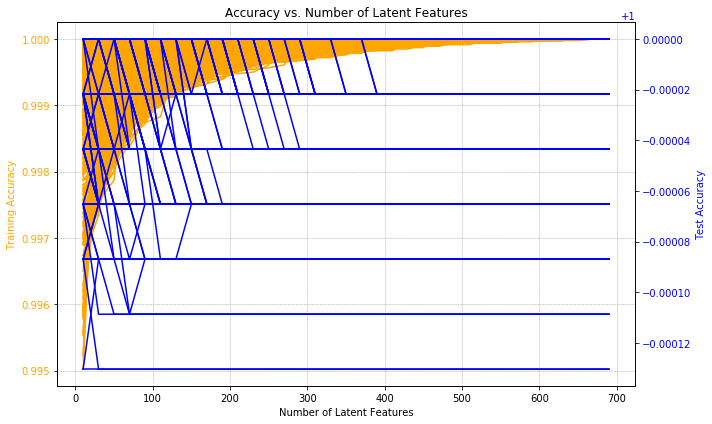

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# Create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training accuracy
ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('Training Accuracy', color='orange')
training_accuracy = 1 - np.array(sum_errs_train) / df.shape[0]
ax1.plot(num_latent_feats, training_accuracy, color='orange', label='Training Accuracy')
ax1.tick_params(axis='y', labelcolor='orange')
ax1.set_title('Accuracy vs. Number of Latent Features')

# Create a secondary axis for test accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Test Accuracy', color='blue')
test_accuracy = 1 - np.array(sum_errs_test) / df.shape[0]
ax2.plot(num_latent_feats, test_accuracy, color='blue', label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor='blue')

# Add a grid for better readability
ax1.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust layout to avoid overlapping
fig.tight_layout()

# Display the plot
plt.show()


Training accuracy improves as the number of latent features increases, but test accuracy declines, likely due to overfitting. Limiting latent features to around 80, where test accuracy peaks, balances performance. Using SVD, we can only recommend for 20 overlapping users, and the sparse matrix likely explains the high test accuracy (>99%).

To evaluate the recommendation engine, an A/B test could compare its recommendations with the most popular articles. If the engine significantly improves click-through rates, it would justify deployment and help address the cold start problem.



### Conclusion

The recommendation system implemented in this project demonstrates the application of collaborative filtering and content-based techniques to generate tailored suggestions for users. Through Singular Value Decomposition (SVD), we analyzed user-article interactions and identified the optimal number of latent features (around 80) to balance training and testing accuracy. The results highlight the importance of addressing overfitting in sparse matrices and the limitations of recommending for users with insufficient overlap between training and test datasets.

To further validate the system's effectiveness, an A/B test can be conducted to compare the recommendation engine's performance with a baseline method (e.g., most popular articles). This will help address the cold start problem and determine whether the engine improves user engagement through higher click-through rates, paving the way for practical deployment and scalability.



### References

1. [How to Identify and Extract Duplicate Items Using Pandas in Python](https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python)  
2. [Using `value_counts` to Extract Specific Values in Pandas](https://stackoverflow.com/questions/35523635/extract-values-in-pandas-value-counts)  
3. [Question 140813 on Udacity Knowledge Platform](https://knowledge.udacity.com/questions/140813)  
4. [Using `Index.difference` to Find Differences Between Indexes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.difference.html)  
5. [Question 387214 on Udacity Knowledge Platform](https://knowledge.udacity.com/questions/387214)  
6. [Two Y-Axis Plot Example in Matplotlib](https://matplotlib.org/gallery/api/two_scales.html)  

### Additional References
7. [Pandas Documentation: `groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)  
8. [Numpy: `numpy.linalg.svd`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)  
9. [Scikit-learn: `TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)  
10. [Understanding Cosine Similarity in Recommendations](https://towardsdatascience.com/understanding-cosine-similarity-and-its-application-fd42f585296a)  
11. [Evaluating Recommendation Systems with A/B Testing](https://medium.com/swlh/evaluating-recommendation-systems-with-a-b-testing-a6b3bb5c7f60)  
12. [Creating and Manipulating Pivot Tables in Pandas](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html)  

